In [1]:
import os

In [2]:
os.chdir('..')

In [3]:
pwd

'/Users/A.IVA/Documents/jupyter_notebooks/coursera_and_blogs/rossmann_competition'

### 1 Data exploration

##### 1.1 Load & preprocess data

In [4]:
import pandas as pd
import numpy as np
import datetime

In [5]:
data_dir = os.path.join('..', 'data', 'rossmann-store-sales', 'source')

def dateparse(x):
    return datetime.datetime.strptime(x, '%Y-%m-%d')

df_store = pd.read_csv( os.path.join(data_dir, 'store.csv'))
df_train = pd.read_csv( os.path.join(data_dir, 'train.csv'), parse_dates=[2], date_parser=dateparse, low_memory=False)
df_test = pd.read_csv( os.path.join(data_dir, 'test.csv'), parse_dates=[3], date_parser=dateparse)

In [6]:
print(df_store.shape, df_train.shape, df_test.shape)
display(df_store.head(2))
display(df_train.head(2))
display(df_test.head(2))

(1115, 10) (1017209, 9) (41088, 8)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0


In [7]:
df_store['CompetitionOpenSince'] = df_store[['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']]\
    .apply(lambda x: datetime.date(int(x[0]), int(x[1]), 1) if x[0] > 0 and x[1] > 0 else pd.NaT, 1)

df_store['CompetitionOpenSince'] = pd.to_datetime(df_store['CompetitionOpenSince'], format='%Y-%m-%d')
df_store = df_store.drop(columns=['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth'])

display(df_store.head(2))

,Store,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSince
0,1,c,a,1270.0,0,NaN,NaN,NaN,2008-09-01
1,2,a,a,570.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2007-11-01


##### 1.2 Explore

In [19]:
tmp = df_train[['Store','Date']] \
    .drop_duplicates() \
    .groupby(by=['Store']) \
    .agg({'Date': 'count'}) \
    .rename(columns={'Date': 'count'})

tmp['count'].value_counts()

942    934
758    180
941      1
Name: count, dtype: int64

In [20]:
tmp[tmp['count'] == 941]

,count
Store,
988,941


In [24]:
tmp[tmp['count'] == 942].head(2)

,count
Store,
1,942
2,942


In [27]:
tmp[tmp['count'] == 758].head(2)

,count
Store,
13,758
20,758


In [22]:
df_train[df_train['Store'] == 988]['Date'].min()

Timestamp('2013-01-02 00:00:00')

In [25]:
df_train[df_train['Store'] == 1]['Date'].min()

Timestamp('2013-01-01 00:00:00')

In [29]:
df_train[df_train['Store'] == 13]['Date'].min(), df_train[df_train['Store'] == 13]['Date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2015-07-31 00:00:00'))

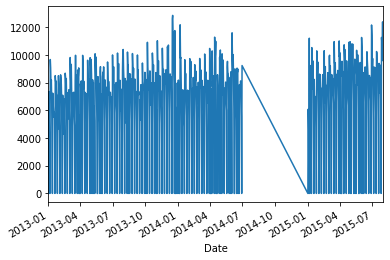

In [32]:
df_train[df_train['Store'] == 20].set_index(['Date'])['Sales'].plot()

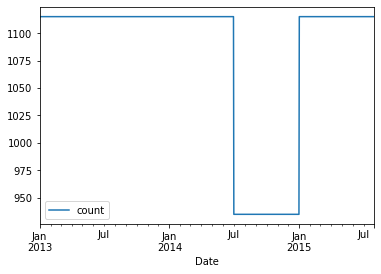

In [34]:
# See which dates are missing for all stores
df_train \
    .groupby(by=['Date']) \
    .agg({'Store': 'count'}) \
    .rename(columns={'Store': 'count'}) \
    .plot()

In [17]:
ix = pd.date_range(start=datetime.date(2013, 1, 1), end=datetime.date(2015, 7, 31), freq='D')
len(ix)

942

In [15]:
934+180+1

1115

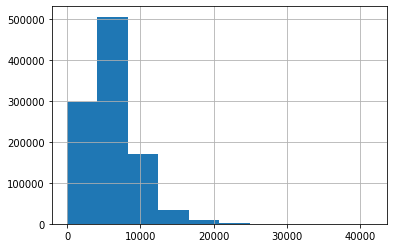

In [8]:
df_train['Sales'].hist()

In [55]:
vc = pd.DataFrame()
vc['all_sales'] = df_train['DayOfWeek'].value_counts()
vc['zero_sales'] = df_train[df_train['Sales']==0]['DayOfWeek'].value_counts()
vc.sort_index()

,all_sales,zero_sales
1,144730,7173
2,145664,1709
3,145665,3743
4,145845,11219
5,145845,7212
6,144730,678
7,144730,141137


In [51]:
display(df_train\
    .groupby(by=['Store']) \
    .agg({'Date': ['min','max']})['Date'] \
    .rename(columns={'min': 'Date_min', 'max': 'Date_max'}) \
    ['Date_min'].value_counts())

display(df_train\
    .groupby(by=['Store']) \
    .agg({'Date': ['min','max']})['Date'] \
    .rename(columns={'min': 'Date_min', 'max': 'Date_max'}) \
    ['Date_max'].value_counts())

2013-01-01    1114
2013-01-02       1
Name: Date_min, dtype: int64

2015-07-31    1115
Name: Date_max, dtype: int64

In [34]:
# join both dfs 
df = df_train.set_index(['Store']) \
    .join(df_store.set_index(['Store'])[['CompetitionOpenSince']]) \
    .reset_index() \
    .sort_values(by=['Store', 'Date']) \
    .reset_index(drop='True') \
    .set_index(['Date'])

df.head(2)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionOpenSince
Date,,,,,,,,,
2013-01-01,1,2,0,0,0,0,a,1,2008-09-01
2013-01-02,1,3,5530,668,1,0,0,1,2008-09-01


##### 1.3 Look at a single store

In [103]:
df1 = df[df['Store'] == 1].copy(deep=True)
df1.head(3)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionOpenSince
Date,,,,,,,,,
2013-01-01,1,2,0,0,0,0,a,1,2008-09-01
2013-01-02,1,3,5530,668,1,0,0,1,2008-09-01
2013-01-03,1,4,4327,578,1,0,0,1,2008-09-01


In [171]:
stores_train = sorted(df['Store'].drop_duplicates())

dfs={}

for store in stores_train:
    
    ix = pd.date_range(start=datetime.date(2013, 1, 1), end=datetime.date(2015, 7, 31), freq='D')
    df_new = df[df['Store'] == 1].copy(deep=True)
    df_new = df_new.reindex(ix)#.fillna(0)

    df_new['Store'] = df_new['Store'].fillna(df1['Store'].min())
    df_new['DayOfWeek'] = df_new.index.map(lambda x: x.weekday() + 1)
    df_new['Sales'] = df_new['Sales'].fillna(0)
    df_new['Customers'] = df_new['Customers'].fillna(0)
    df_new['Open'] = df_new['Open'].fillna(0)
    df_new['Promo'] = df_new['Promo'].fillna(0)
    df_new['StateHoliday'] = df_new['StateHoliday'].fillna('a')
    df_new['SchoolHoliday'] = df_new['SchoolHoliday'].fillna(1)
    df_new['CompetitionOpenSince'] = df_new['CompetitionOpenSince'].fillna(method='bfill')
    
    dfs[store] = df_new

In [104]:
# There should be a better way to deal with different groups of pd.DataFrames... 
ix = pd.date_range(start=datetime.date(2013, 1, 1), end=datetime.date(2015, 7, 31), freq='D')
df1 = df1.reindex(ix).fillna(0)

# fill nans
#
df1['Store'] = df1['Store'].fillna(df1['Store'].min())
df1['DayOfWeek'] = df1.index.map(lambda x: x.weekday() + 1)
df1['Sales'] = df1['Sales'].fillna(0)
df1['Customers'] = df1['Customers'].fillna(0)
df1['Open'] = df1['Open'].fillna(0)
df1['Promo'] = df1['Promo'].fillna(0)
df1['StateHoliday'] = df1['StateHoliday'].fillna('a')
df1['SchoolHoliday'] = df1['SchoolHoliday'].fillna(1)
df1['CompetitionOpenSince'] = df1['CompetitionOpenSince'].fillna(method='bfill')

In [105]:
df1.head(3)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionOpenSince
2013-01-01,1,2,0,0,0,0,a,1,2008-09-01
2013-01-02,1,3,5530,668,1,0,0,1,2008-09-01
2013-01-03,1,4,4327,578,1,0,0,1,2008-09-01


In [106]:
df1 = pd.concat([df1.drop(['StateHoliday'],1), pd.get_dummies(df1['StateHoliday'], prefix='state_h_')], axis=1, sort=False)
df1.head(3)

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionOpenSince,state_h__0,state_h__a,state_h__b,state_h__c
2013-01-01,1,2,0,0,0,0,1,2008-09-01,0,1,0,0
2013-01-02,1,3,5530,668,1,0,1,2008-09-01,1,0,0,0
2013-01-03,1,4,4327,578,1,0,1,2008-09-01,1,0,0,0


In [107]:
df1['last_competitor_here'] = (df1['CompetitionOpenSince'] <= df1.index).astype(int)

##### 1.4 Monthly behaviour

In [108]:
df1 = df1.resample('M').mean()
df1.head(3)

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,state_h__0,state_h__a,state_h__b,state_h__c,last_competitor_here
2013-01-31,1.0,3.903226,4142.935484,512.870968,0.838710,0.322581,0.354839,0.967742,0.032258,0.000000,0.0,1.0
2013-02-28,1.0,4.000000,4473.964286,542.464286,0.857143,0.357143,0.000000,1.000000,0.000000,0.000000,0.0,1.0
2013-03-31,1.0,4.193548,4682.870968,566.903226,0.806452,0.483871,0.161290,0.967742,0.000000,0.032258,0.0,1.0


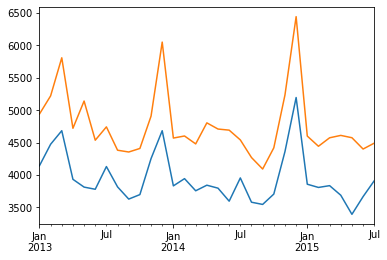

In [110]:
# Maybe we have to divide by 'Open' in order to remove the effect of 
# fewer sales based on the fact the the number of days when the store was open is reduced...
#
df1['Sales'].plot()
(df1['Sales']/df1['Open']).plot()
plt.show()

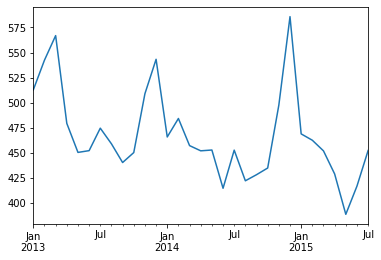

In [111]:
df1['Customers'].plot()
plt.show()

In [119]:
# Add two exogen variables (is_dec, is_jul) which will subtract the peaks from these two months.
df1['is_jul'] = (df1.index.month == 7).astype(int)
df1['is_dec'] = (df1.index.month == 12).astype(int)

In [120]:
df1.head(3)

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,state_h__0,state_h__a,state_h__b,state_h__c,last_competitor_here,is_jul,is_dec
2013-01-31,1.0,3.903226,4142.935484,512.870968,0.838710,0.322581,0.354839,0.967742,0.032258,0.000000,0.0,1.0,0,0
2013-02-28,1.0,4.000000,4473.964286,542.464286,0.857143,0.357143,0.000000,1.000000,0.000000,0.000000,0.0,1.0,0,0
2013-03-31,1.0,4.193548,4682.870968,566.903226,0.806452,0.483871,0.161290,0.967742,0.000000,0.032258,0.0,1.0,0,0


In [130]:
import itertools
import statsmodels.api as sm
from typing import List, Dict, Tuple, Union, Any

def get_arima_ic(p_range: Tuple = (0, 5), d_range: Tuple = (0, 1),
                 q_range: Tuple = (0, 5),
                 endog=None, exog=None, criterion='aic') \
        -> List[Dict]:
    """ Pick the right order (pdq) for an ARIMA model.
    Do not compare combinations with different `d`.

    :param p_range: lower and upper limit for possible p-values;
        All pdq combinations where p is in the range [lower limit, upper limit)
        will be generated.
    :param d_range:
    :param q_range:
    :param endog: endogen variables
    :param exog: exogen variables
    :param criterion: aic (Akaike information criterion) or bic
        (Bayesian information criterion)
    :return:
        list of dicts with scores for different information criteria;
        list is ordered based on the scores of one of the information criteria.
    """

    rp, rd, rq = range(*p_range), range(*d_range), range(*q_range)

    ics = []

    for pdq in list(itertools.product(rp, rd, rq)):

        try:
            mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=pdq, trend='ct')
            fit_res = mod.fit(disp=False)
            ics.append({
                'pdq': pdq,
                'aic': fit_res.aic,
                'bic': fit_res.bic
            })
        except:
            ics.append({
                'pdq': pdq,
                'aic': np.nan,
                'bic': np.nan
            })

    ics = sorted(ics, key=lambda x: x[criterion])

    return ics

In [141]:
# additive exogen
results = get_arima_ic(p_range=(0, 5), 
                       d_range=(0, 1),
                       q_range=(0, 5),
                       endog=df1['Sales'], 
                       exog=df1[['Open', 'is_jul', 'is_dec', 'last_competitor_here']], 
                       criterion='aic')

/Users/A.IVA/opt/anaconda3/envs/rossmann/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/A.IVA/opt/anaconda3/envs/rossmann/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/A.IVA/opt/anaconda3/envs/rossmann/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/A.IVA/opt/anaconda3/envs/rossmann/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/A.IVA/opt/anaconda3/envs/rossmann/lib/python3.7/site-packages

In [143]:
results

[{'pdq': (0, 0, 1), 'aic': 439.04667832481306, 'bic': 450.51857596069425},
 {'pdq': (1, 0, 0), 'aic': 439.178084215068, 'bic': 450.6499818509492},
 {'pdq': (2, 0, 0), 'aic': 440.67319207323305, 'bic': 453.57907691359935},
 {'pdq': (0, 0, 2), 'aic': 441.1547732808977, 'bic': 454.060658121264},
 {'pdq': (0, 0, 0), 'aic': 441.5027335378903, 'bic': 451.54064396928635},
 {'pdq': (1, 0, 1), 'aic': 441.66496360538486, 'bic': 454.57084844575115},
 {'pdq': (1, 0, 2), 'aic': 442.2678397717497, 'bic': 456.6077118166012},
 {'pdq': (0, 0, 3), 'aic': 442.68077363183704, 'bic': 457.0206456766885},
 {'pdq': (3, 0, 0), 'aic': 442.97258569264136, 'bic': 457.3124577374928},
 {'pdq': (2, 0, 1), 'aic': 443.3599569848355, 'bic': 457.69982902968695},
 {'pdq': (2, 0, 3), 'aic': 444.3514305705005, 'bic': 461.5592770243222},
 {'pdq': (2, 0, 2), 'aic': 444.50442960835653, 'bic': 460.27828885769316},
 {'pdq': (4, 0, 0), 'aic': 444.960958007253, 'bic': 460.7348172565896},
 {'pdq': (3, 0, 1), 'aic': 446.50721469767

In [144]:
mod = sm.tsa.statespace.SARIMAX(endog=df1['Sales'], 
                                exog=df1[['Open', 'is_jul', 'is_dec']], 
                                order=results[0]['pdq'], 
                                trend='ct')
fit_res = mod.fit(disp=False)

/Users/A.IVA/opt/anaconda3/envs/rossmann/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [145]:
fit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   31
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -214.151
Date:                Sun, 01 Dec 2019   AIC                            442.303
Time:                        08:16:20   BIC                            452.340
Sample:                    01-31-2013   HQIC                           445.575
                         - 07-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    131.9350   1457.074      0.091      0.928   -2723.878    2987.748
drift        -13.2719      8.023     -1.654      0.098     -28.996       2.453
Open        4748.4244   1790.257      2.652      0.008    1239.585    8257.264
is_jul        44.1875    337.986      0.131      0.896    -618.253     706.628
is_dec      1201.5706    262.939      4.570      0.000     686.219    1716.922
ma.L1          0.2654      0.213      1.248      0.212      -0.151       0.682
sigma2      5.823e+04   1.79e+04      3.250      0.001    2.31e+04    9.33e+04
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 4.64
Prob(Q):                               nan   Prob(JB):                         0.10
Heteroskedasticity (H):               0.38   Skew:                             0.85
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [140]:
# fit_res.forecast(1)

##### 1.5 Check how stamodels.tsa deals with missing dates

In [37]:
ix = pd.date_range(start=datetime.date(2013, 1, 1), end=datetime.date(2015, 7, 31), freq='D')
# df_new = df[df['Store'] == 1].copy(deep=True)
# df_new = df_new.reindex(ix).fillna(0)

In [41]:
y = np.arange(100) * 0.1 + 20
y = pd.DataFrame(data=y, index=ix[:len(y)], columns=['y'])
y

,y
2013-01-01,20.0
2013-01-02,20.1
2013-01-03,20.2
2013-01-04,20.3
2013-01-05,20.4
...,...
2013-04-06,29.5
2013-04-07,29.6
2013-04-08,29.7
2013-04-09,29.8


In [52]:
pd.concat([y.iloc[:20], y.iloc[50:]])
# y.iloc[:3]

,y
2013-01-01,20.0
2013-01-02,20.1
2013-01-03,20.2
2013-01-04,20.3
2013-01-05,20.4
2013-01-06,20.5


In [43]:
import statsmodels.api as sm

In [53]:
mod = sm.tsa.statespace.SARIMAX(endog=pd.concat([y.iloc[:20], y.iloc[50:]]), 
                                exog=None, 
                                order=(0,0,0), 
                                trend='ct')
fit_res = mod.fit(disp=False)

/Users/A.IVA/opt/anaconda3/envs/rossmann/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [54]:
fit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   70
Model:                        SARIMAX   Log Likelihood                 -87.522
Date:                Sun, 01 Dec 2019   AIC                            181.044
Time:                        10:43:23   BIC                            187.790
Sample:                             0   HQIC                           183.724
                                 - 70                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     20.3247      0.204     99.512      0.000      19.924      20.725
drift          0.1526      0.006     24.430      0.000       0.140       0.165
sigma2         0.7137      0.197      3.626      0.000       0.328       1.099
===================================================================================
Ljung-Box (Q):                      503.24   Jarque-Bera (JB):                 5.13
Prob(Q):                              0.00   Prob(JB):                         0.08
Heteroskedasticity (H):               0.26   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         1.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### Explore all state holydays

In [ ]:
StateHoliday

In [147]:
df_train.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


In [155]:
df_train[['Date', 'StateHoliday']]\
    .drop_duplicates() \
    .groupby(['Date']) \
    .agg({'StateHoliday': 'count'}) \
    .rename(columns={'StateHoliday': 'count'}) \
    .sort_values(by=['count'], ascending=[False])

,count
Date,
2014-06-19,2
2013-08-15,2
2013-10-31,2
2013-11-01,2
2015-06-04,2
...,...
2013-11-18,1
2013-11-19,1
2013-11-21,1


In [158]:
df_train['StateHoliday'].value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [78]:
for el in ['Open', 'Promo', 'StateHoliday', 'SchoolHoliday']:
    print('\n', el)
    print(df1[el].value_counts())


 Open
1    781
0    161
Name: Open, dtype: int64

 Promo
0    582
1    360
Name: Promo, dtype: int64

 StateHoliday
0    915
a     17
b      6
c      4
Name: StateHoliday, dtype: int64

 SchoolHoliday
0    749
1    193
Name: SchoolHoliday, dtype: int64


In [75]:
# TODO !
df1.dtypes

Store                            int64
DayOfWeek                        int64
Sales                            int64
Customers                        int64
Open                             int64
Promo                            int64
StateHoliday                    object
SchoolHoliday                    int64
CompetitionOpenSince    datetime64[ns]
dtype: object

In [ ]:
# %matplotlib inline
import matplotlib.pyplot as plt
import math

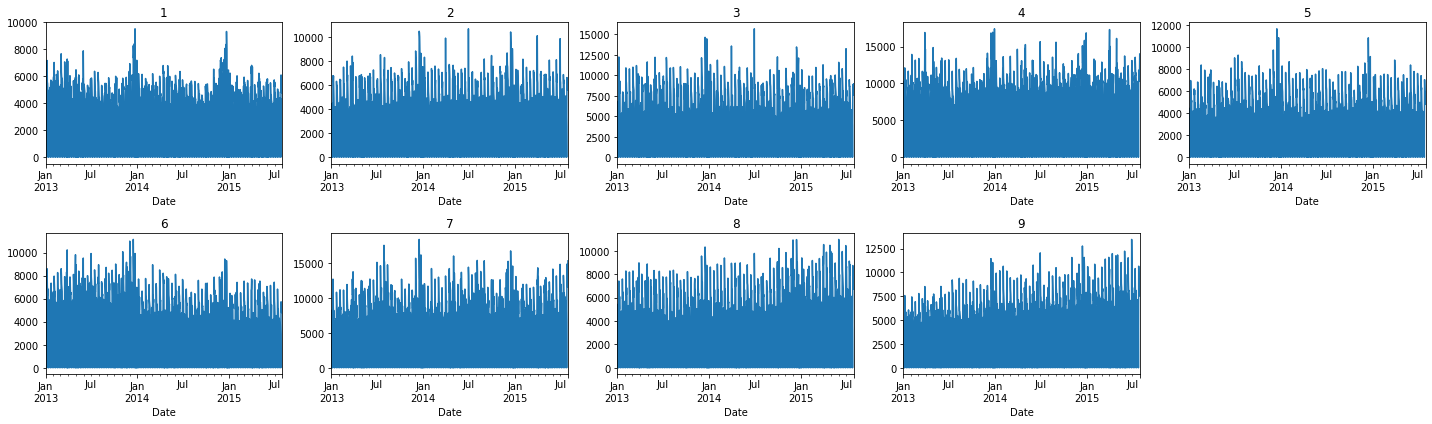

In [36]:
stores = range(1,10)

r, c = math.ceil(len(stores)/5.), 5

plt.figure(figsize=(20, r * 3))

for idx, store in enumerate(stores, 1):
    
    plt.subplot(r, c, idx)
    df[df['Store'] == store]['Sales'].plot()
    plt.title(store)
    plt.tight_layout()
    
plt.show()


In [ ]:
# load data 
# get days when the store is open 
# fill in missing values (even if....)
# endogen, exogen variables ...

